In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pck
import sys 
import os
import importlib.util
from scipy.constants import c

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/andre/Documents/UFCG/Photonics/Arquivos/Photonic-temperature-sensor'))
spec_win.loader.exec_module(lumapi)

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v221/api/python")
# sys.path.append(os.path.dirname('C:/Users/PC/Documents/Photonics/Photonic-temperature-sensor'))
# spec_win.loader.exec_module(lumapi)

<font size = 6>FDTD component

In [2]:
sensor = lumapi.FDTD(filename = 'coupling.fsp')

In [21]:
# Initial Parameters
W = 500e-9
Gap = 200e-9
height = 250e-9
radius = 4e-6
accuracy = 3
points = 101

sensor.switchtolayout()
sensor.selectall()
sensor.delete()

# Add substrate

sensor.addrect()
sensor.set({
    'name'                                              : 'substrate',
    'x'                                                 : 20e-6,
    'x span'                                            : 40e-6,
    'y'                                                 : 10e-6,
    'y span'                                            : 20e-6,
    'z'                                                 : -1e-6,
    'z span'                                            : 2e-6,
    'material'                                          : 'SiO2_dT',
    'override mesh order from material database'        : True,
    'mesh order'                                        : 3
})

# Ring resonator

sensor.addobject('ring_resonator')
sensor.set({
    'name'          : 'Ring',
    'material'      : 'Silicon_dT',
    'x'             : 10e-6,
    'y'             : 10e-6,
    'z'             : 0.125e-6,
    'lc'            : 0,
    'Gap'           : Gap,
    'radius'        : radius,
    'base width'    : W,
    'base height'   : height,
    'x span'        : 20e-6
})
sensor.setnamed('Ring::outer_bottom', {
    'enabled'       : False
})
sensor.setnamed('Ring::outer_top', {
    'override mesh order from material database'        : True,
    'mesh order'                                        : 1
})
sensor.setnamed('Ring::arc1', {
    'override mesh order from material database'        : True,
    'mesh order'                                        : 1
})
sensor.setnamed('Ring::arc2', {
    'enabled'                                           : False,
})
sensor.setnamed('Ring::arc3', {
    'enabled'                                           : False,
})
sensor.setnamed('Ring::arc4', {
    'override mesh order from material database'        : True,
    'mesh order'                                        : 1
})
sensor.addrect()
sensor.set({
    'name'                                              : 'Arm',
    'x'                                                 : 20e-6 + radius,
    'x span'                                            : W,
    'y max'                                             : 10e-6,
    'y min'                                             : 6e-6,
    'z min'                                             : 0,
    'z max'                                             : height,
    'material'                                          : 'Silicon_dT',
    'override mesh order from material database'        : True,
    'mesh order'                                        : 1,
})

# Slab

sensor.addrect()
sensor.set({
    'name'                                              : 'Slab',
    'x'                                                 : 20e-6,
    'x span'                                            : 40e-6,
    'y'                                                 : 10e-6,
    'y span'                                            : 20e-6,
    'z min'                                             : 0,
    'z max'                                             : 50e-9,
    'material'                                          : 'Silicon_dT',
    'override mesh order from material database'        : True,
    'mesh order'                                        : 1
})

# Simulation area

sensor.addfdtd()
sensor.set({
    'x'                         : 20e-6,
    'x span'                    : 13e-6,
    'y max'                     : 17e-6,
    'y min'                     : 7e-6,
    'z'                         : 0.125e-6,
    'z span'                    : 2.5e-6,
    'simulation time'           : 4000e-15,
    'simulation temperature'    : 300,
    'mesh accuracy'             : accuracy,
    'set simulation bandwidth'  : True,
    'simulation wavelength min' : 1530e-9,
    'simulation wavelength max' : 1570e-9,
})

# Ports
sensor.addport()
sensor.set({
    'x'                         : 14.5e-6,
    'y'                         : 10e-6 + Gap + radius + W,
    'y span'                    : 3e-6,
    'z'                         : 0.125e-6,
})
sensor.addport()
sensor.set({
    'x'                         : 25.5e-6,
    'y'                         : 10e-6 + Gap + radius + W,
    'y span'                    : 3e-6,
    'z'                         : 0.125e-6,
    'direction'                 : 'Backward',
})
sensor.addport()
sensor.set({
    'injection axis'            : 'y-axis',
    'x'                         : 20e-6 + radius,
    'x span'                    : 3e-6,
    'y'                         : 8e-6,
    'z'                         : 0.125e-6,
})
sensor.setnamed('FDTD::ports', {
    'monitor frequency points'          : points,
})

sensor.addprofile()
sensor.set({
    'name'                                  : 'profile',
    'x'                                     : 20e-6,
    'x span'                                : 13e-6,
    'y max'                                 : 17e-6,
    'y min'                                 : 7e-6,
    'z'                                     : 0.125e-6,
    'override global monitor settings'      : True,
    'frequency points'                      : points
})

In [22]:
sensor.run()

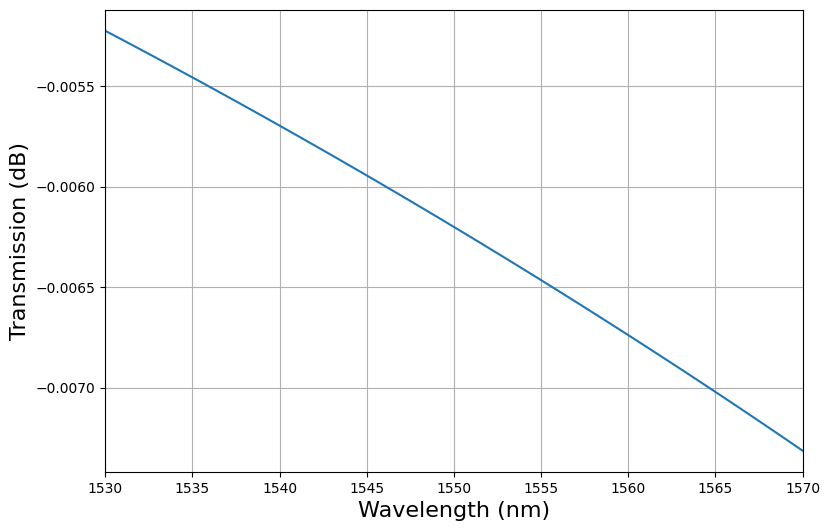

In [25]:
output = sensor.getresult('FDTD::ports::port 3', 'T')
wavelength = output['lambda']
T = output['T']

plt.figure(figsize = (9,6))
plt.plot(wavelength*1e9, T)
plt.xlim(1530, 1570)
#plt.ylim(-10, 0)
plt.xlabel('Wavelength (nm)', fontsize = 16)
plt.ylabel('Transmission (dB)', fontsize = 16)
plt.grid(True)
plt.savefig('Imagens/Coupling' + '.png')

<font size = 6>Interconnect

In [3]:
inter = lumapi.INTERCONNECT('dispositivo.icp')

In [41]:
# Ring parameters

loss = 3200 # dB/m
neff = 2.57 # at 300 K
ng = 4.13 # at 300 K
D = 349.6 # ps/km nm at 1550 nm
S = -5.1 # ps/km nm^2 at 1550 nm
length = 25.13e-6 # at 300 K
points = 100000 # number of points
Coupling = 0.0059
wavelength_min = 1530e-9 
wavelength_max = 1570e-9


inter.switchtodesign()

inter.setnamed('ONA_1', {
    'input parameter'           : 'start and stop',
    'start frequency'           : c/wavelength_min,
    'stop frequency'            : c/wavelength_max,
    'number of points'          : points,
})
inter.setnamed('RING_1', {
    'frequency'                 : c/wavelength_min,
    'length'                    : length,
    'loss 1'                    : loss,
    'effective index 1'         : neff,
    'group index 1'             : ng,
    'dispersion 1'              : D*1e-6,
    'dispersion slope 1'        : S*1e3,
    'coupling coefficient 1'    : Coupling,
})

In [42]:
couplings = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

data = np.zeros((len(couplings), points))

for i, coupling in enumerate(couplings):
    inter.switchtodesign()

    inter.setnamed('RING_1', {
        'coupling coefficient 1'    : coupling,
    })

    inter.run()

    output = inter.getresult('ONA_1', 'input 1/mode 1/gain')
    wavelength = output['wavelength']
    data[i][:] = output['TE gain (dB)']

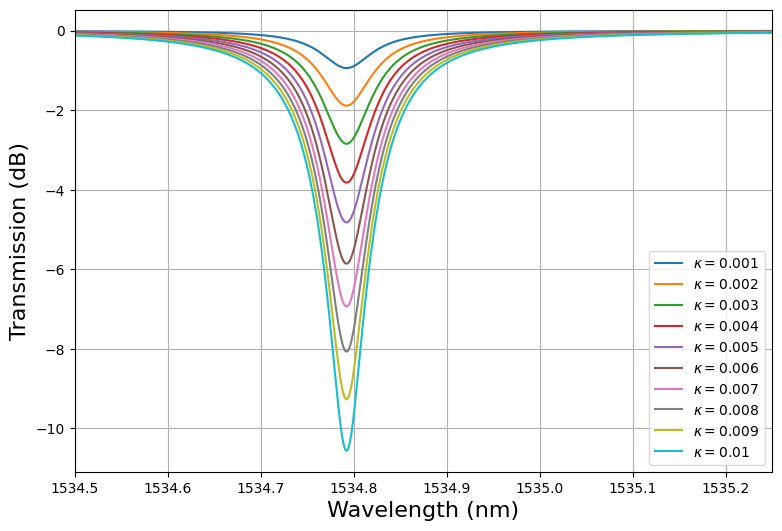

In [46]:
plt.figure(figsize = (9,6))
for i in range(len(couplings)):
    plt.plot(wavelength*1e9, data[i][:], label = r'$\kappa = {}$'.format(couplings[i]))

plt.xlim(1534.5, 1535.25)
#plt.ylim(-10, 0)
plt.xlabel('Wavelength (nm)', fontsize = 16)
plt.ylabel('Transmission (dB)', fontsize = 16)
plt.legend(loc = 'lower right')
plt.grid(True)
plt.savefig('Imagens/Coupling sweep' + '.png')